**Gensim** is billed as a Natural Language Processing package that does ‘Topic Modeling for Humans’. But it is practically much more than that. It is a leading and a state-of-the-art package for processing texts, working with word vector models and for building topic models.

But the width and scope of facilities to build and evaluate topic models are unparalleled in gensim, plus many more convenient facilities for text processing.

Also, another significant advantage with gensim is: it lets you handle large text files without having to load the entire file in mem
For more info, follow this link: [https://www.kaggle.com/code/nikolayromanenkov/gensim-tutorial](http://)ory.

# Word2Vec
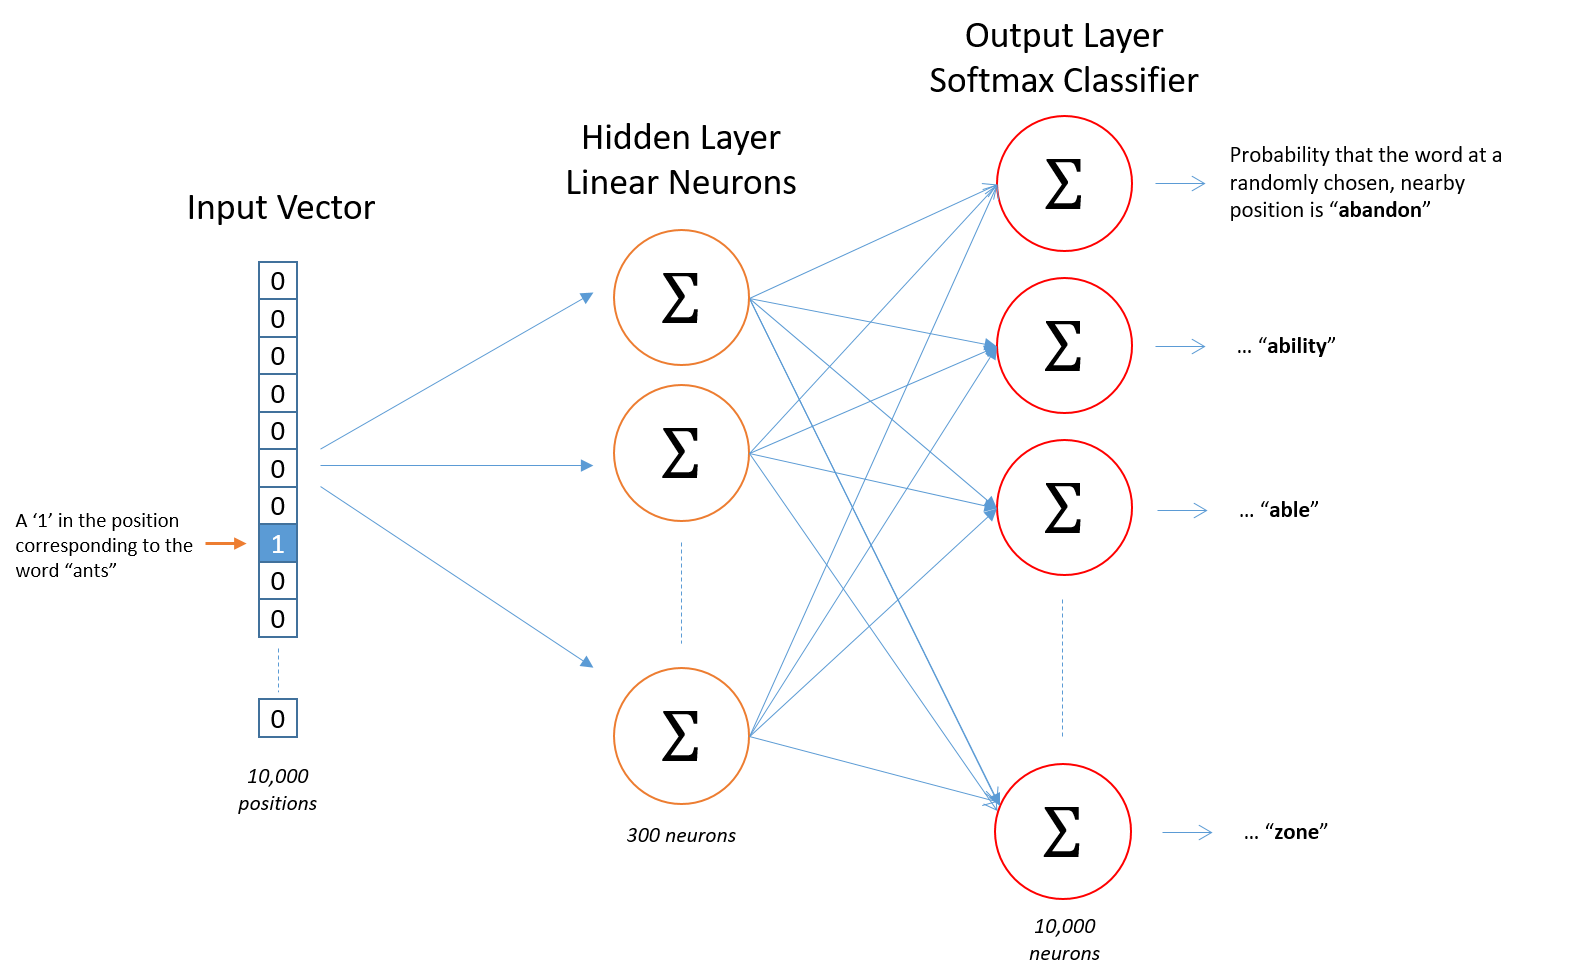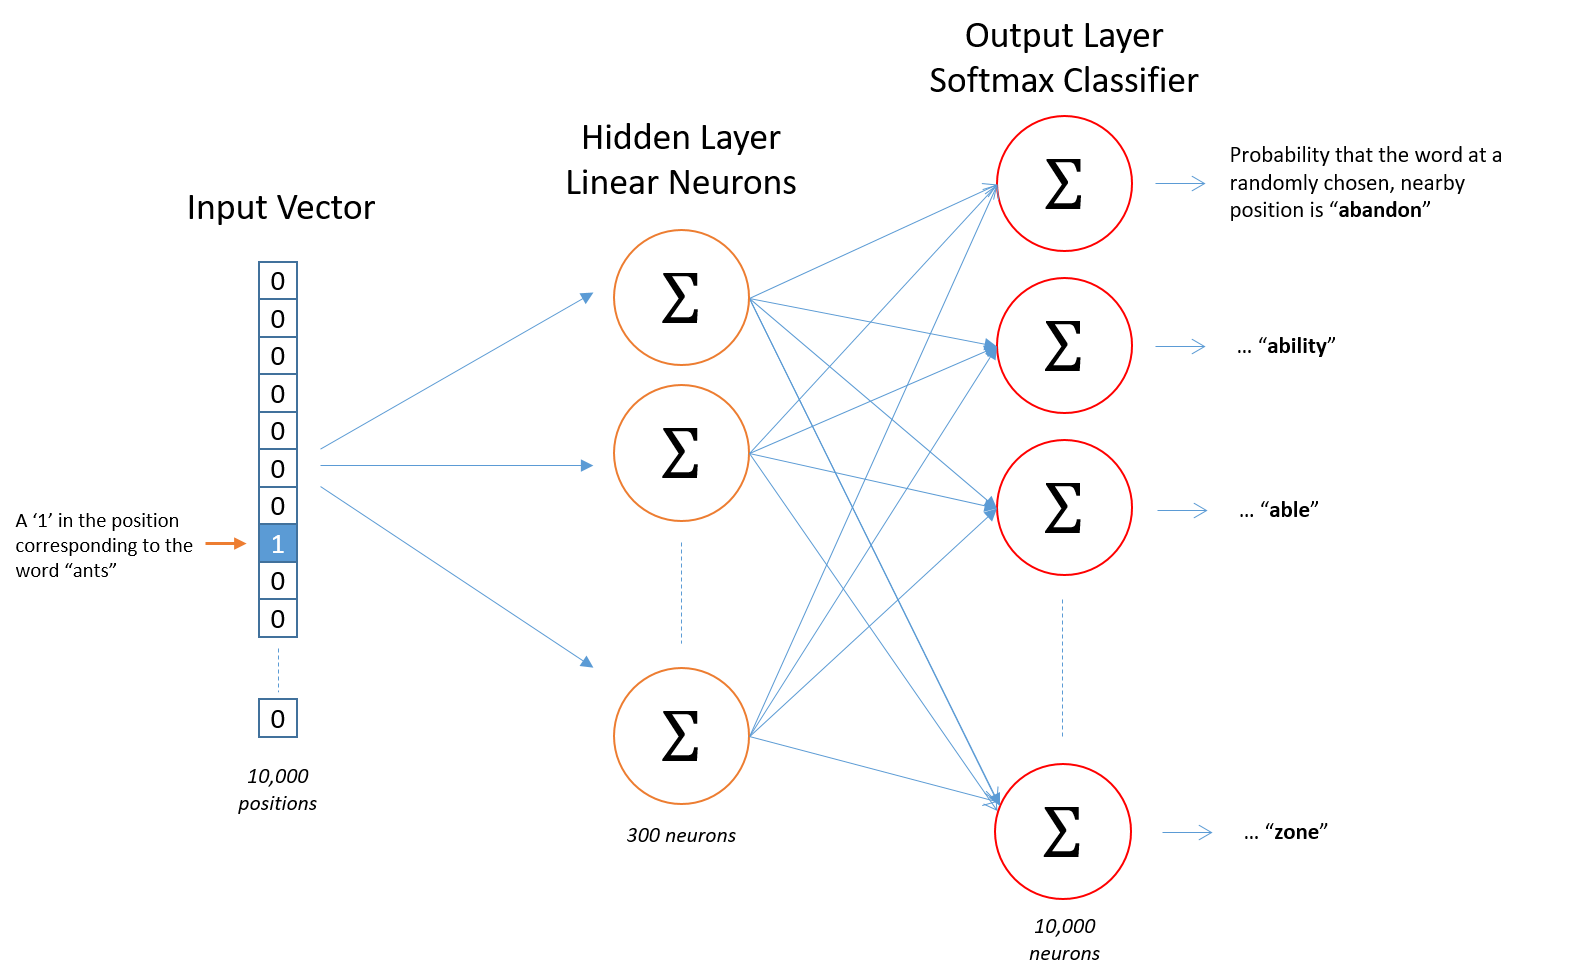

Word2Vec was introduced in two papers between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by Gensim.

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representatio
From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering. 
word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks.

Reference 1: [https://www.tensorflow.org/text/tutorials/word2vec](http://)

Reference 2: [https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial#Material-for-more-in-depths-understanding](http://)n.

In [ ]:
!pip install gensim==3.8.3

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import plotly.express as px
import warnings;
warnings.filterwarnings('ignore')

In [ ]:
import gensim

**Dataset:**

The "Online Retail Transaction" dataset contains information on transactions made by customers through an online retail platform. The dataset includes data on the products that were purchased, the quantity of each product, the date and time of each transaction, the price of each product, the unique identifier for each customer who made a purchase, and the country where each customer is located.

In [10]:
df = pd.read_excel('/kaggle/input/online-retail-transactions-dataset/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [9]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [11]:
df.shape

(541909, 8)

In [20]:
# remove missing values
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
# Convert the StockCode to string datatype becuase based on data, we have some letter in StockCode
df['StockCode']= df['StockCode'].astype(str)

In [18]:
# Check out the number of unique customers in our dataset
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [19]:
len(df["Quantity"].unique())

671

In [ ]:
df["Quantity"].unique()

In [ ]:
df.shape

In [ ]:
#we have some negetive numbers for quantity that is not rational. We filter them
df = df[df["Quantity"]>0]

In [ ]:
df.shape

In [ ]:
df["Quantity"].unique()

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [ ]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

In [ ]:
len(purchases_train)

In [ ]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

In [ ]:
len(purchases_val)

In [ ]:
df.info()

In [ ]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [ ]:
print_unique_col_values(df)

In [ ]:
fig = px.histogram(df, x="Country")
fig.show()

# Build word2vec embedings for products 

In [ ]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

#window=10: Specifies the maximum distance between the current word and the words within its context. A window size of 10 means the model considers 10 words to the left and 10 words to the right as the context for each target word.
#sg=1: Determines the training algorithm to be used. sg=1 indicates the use of the Skip-Gram model, which tries to predict the context words given a target word. If sg=0, it would use the CBOW (Continuous Bag of Words) model instead, which predicts the target word from the context.
#hs=0: Specifies whether to use Hierarchical Softmax or Negative Sampling. Here, hs=0 means that Hierarchical Softmax is not used, and Negative Sampling will be used instead.
#negative=10: Sets the number of "noise words" (negative samples) to be drawn for each positive example in training. Negative sampling is a technique to improve training efficiency, and setting negative=10 means that 10 noise words will be sampled for each target word.
#alpha=0.03: Sets the initial learning rate, which controls how much the model adjusts weights with each training step. A higher value will result in faster convergence initially but may risk missing a more optimal solution.
#min_alpha=0.0007: Specifies the minimum learning rate. Word2Vec uses a learning rate decay over time, so the learning rate will decrease gradually from alpha to min_alpha during training.
#seed=14: Sets the random seed for reproducibility. By fixing a seed, you can ensure that the model's results are the same each time you train it (given that other factors remain constant).

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

In [ ]:
# save word2vec model
model.save("word2vec_2.model")

In [ ]:
# when the model is finalized, we can use init_sims, it can make faster our model
model.init_sims(replace=True)

In [ ]:
print(model)

In [ ]:
X = model[model.wv.vocab]

X.shape

Visualize word2vec Embeddings:
It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can’t even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction.

UMAP, at its core, works very similarly to t-SNE - both use graph layout algorithms to arrange data in low-dimensional space. In the simplest sense, UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible. While the mathematics it uses to construct the high-dimensional graph is advanced, the intuition behind them is remarkably simple.

In [ ]:
!pip install umap-learn

In [ ]:
#collapse
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

# Generate and validate recommendations

We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product’s vector.
Let’s first create a product-ID and product-description dictionary to easily map a product’s description to its ID and vice versa

In [ ]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
products_dict

In [ ]:
# test the dictionary
products_dict['84029E']

In [ ]:
def similar_products(v, n = 6): # we are looking for 6 product similar to current product
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms     

In [ ]:
similar_products(model['90019A'])

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
purchases_val[0]

In [ ]:
aggregate_vectors(purchases_val[0]).shape

In [ ]:
similar_products(aggregate_vectors(purchases_val[0]))

In [ ]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))